In [2]:
import sys
!{sys.executable} -m ensurepip --upgrade
!{sys.executable} -m pip install --upgrade pip setuptools wheel
!{sys.executable} -m pip install wordcloud


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /var/folders/gz/bhmz7vj94s7207h9k2_rgndc0000gn/T/tmpt99g3qc7
Defaulting to user installation because normal site-packages is not writeable
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [setuptools] 1/2 [setuptools]
Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
from wordcloud import WordCloud


In [1]:
# --- Reload processed dataset for model interpretation ---
import pandas as pd

# Path to your cleaned dataset (adjust if needed)
df = pd.read_csv("../data/processed/reported_reviews_clean.csv")

print("✅ Data loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Sanity check: display unique classes
print("\nUnique labels in 'reason' or 'reason_fixed':")
print(df["reason"].dropna().unique()[:10])
if "reason_fixed" in df.columns:
    print("\n'reason_fixed' also found with", df["reason_fixed"].nunique(), "unique values.")
else:
    print("⚠️ No 'reason_fixed' column detected. Make sure you ran 03_feature_expansion before exporting.")


✅ Data loaded successfully!
Shape: (32206, 10)
Columns: ['object_id', 'complex_id', 'vote_reason_id', 'reason', 'date_created', 'date_updated', 'review_text', 'text_len', 'day_of_week', 'hour_of_day']

Unique labels in 'reason' or 'reason_fixed':
['It contains threats, lewdness or hate speech'
 "It's for the wrong community" 'It contains false information'
 "It's influenced by COVID-19 / conavirus"
 'It contains irrelevant information that is not useful'
 'It contains promotional materials'
 "It violates ApartmentRatings' privacy standards"
 'It was posted by a competitor, ex-employee or evicted resident'
 'It was posted by someone affiliated with the community' '13']
⚠️ No 'reason_fixed' column detected. Make sure you ran 03_feature_expansion before exporting.


In [2]:
# --- Setup
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Paths
CLEAN_PATH = "../data/processed/reported_reviews_clean.csv"

# Load cleaned data
df = pd.read_csv(CLEAN_PATH)
print("Shape:", df.shape)
df.head(2)


Shape: (32206, 10)


,object_id,complex_id,vote_reason_id,reason,date_created,date_updated,review_text,text_len,day_of_week,hour_of_day
0,112885551,9.723591e+14,6,"It contains threats, lewdness or hate speech",2021-09-27 13:52:34,2021-09-27 13:52:34,Initially I was excited about moving to Settle...,1052.0,Monday,13.0
1,112795026,9.199332e+18,1,It's for the wrong community,2021-08-23 17:11:15,2021-08-23 17:11:15,Love my apartment and the staff here. I like t...,209.0,Monday,17.0


In [3]:
# --- Repair missing feature columns and do a safe stratified split

import re, string
import pandas as pd
from math import ceil
from sklearn.model_selection import train_test_split

PUNCT = set(string.punctuation)

def count_upper_words(text: str) -> int:
    return sum(1 for w in re.findall(r"[A-Za-z]{2,}", str(text)) if w.isupper())

def count_exclamation(text: str) -> int:
    return str(text).count("!")

def count_punctuation(text: str) -> int:
    return sum(1 for ch in str(text) if ch in PUNCT)

# 1) Ensure base text column exists
if "text" not in df.columns:
    df["text"] = df["review_text"].astype(str)

# 2) Ensure numeric feature columns exist (idempotent)
if "text_len" not in df.columns:
    df["text_len"] = df["text"].str.len()
if "upper_words" not in df.columns:
    df["upper_words"] = df["text"].apply(count_upper_words)
if "exclamation" not in df.columns:
    df["exclamation"] = df["text"].apply(count_exclamation)
if "punctuation" not in df.columns:
    df["punctuation"] = df["text"].apply(count_punctuation)

num_cols = ["text_len","upper_words","exclamation","punctuation"]

# 3) Clean labels and drop empties (idempotent)
df["reason"] = df["reason"].astype(str).str.strip()
mask = (df["text"].str.strip().ne("")) & (df["reason"].str.strip().ne(""))
df = df.loc[mask].copy()

# 4) Merge rare classes if needed (to make stratify possible)
TEST_SIZE = 0.2
min_count_for_stratify = ceil(1 / TEST_SIZE)  # need >=5 when test_size=0.2

if "reason_fixed" not in df.columns:
    counts = df["reason"].value_counts()
    df["reason_fixed"] = df["reason"].where(
        df["reason"].map(counts) >= min_count_for_stratify,
        "Other"
    )

# 5) Final split
X = df[["text"] + num_cols].copy()
y = df["reason_fixed"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

print("Shapes:", X_train.shape, X_test.shape)
print("Classes:", y.nunique(), " | counts:\n", y.value_counts())


Shapes: (25764, 5) (6442, 5)
Classes: 11  | counts:
 reason_fixed
It contains false information                                     6794
It was posted by a competitor, ex-employee or evicted resident    6167
It contains threats, lewdness or hate speech                      5546
It violates ApartmentRatings' privacy standards                   4381
It was posted by someone affiliated with the community            4129
It's for the wrong community                                      2017
It contains irrelevant information that is not useful             1798
It contains promotional materials                                 1135
It's influenced by COVID-19 / conavirus                            213
nan                                                                 16
Other                                                               10
Name: count, dtype: int64


In [4]:
# ✅ Fill missing numeric features before training
for c in ["text_len", "upper_words", "exclamation", "punctuation"]:
    if c in X_train.columns:
        X_train[c] = X_train[c].fillna(0)
        X_test[c] = X_test[c].fillna(0)

# ✅ Fill missing text fields as empty strings
X_train["text"] = X_train["text"].fillna("")
X_test["text"] = X_test["text"].fillna("")


                                                                precision    recall  f1-score   support

                                 It contains false information       0.50      0.13      0.20      1359
         It contains irrelevant information that is not useful       0.22      0.25      0.24       360
                             It contains promotional materials       0.22      0.61      0.32       227
                  It contains threats, lewdness or hate speech       0.44      0.45      0.45      1109
               It violates ApartmentRatings' privacy standards       0.32      0.41      0.36       876
It was posted by a competitor, ex-employee or evicted resident       0.41      0.34      0.37      1234
        It was posted by someone affiliated with the community       0.49      0.47      0.48       826
                                  It's for the wrong community       0.16      0.31      0.22       403
                       It's influenced by COVID-19 / conavirus 

/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

<Figure size 900x700 with 0 Axes>

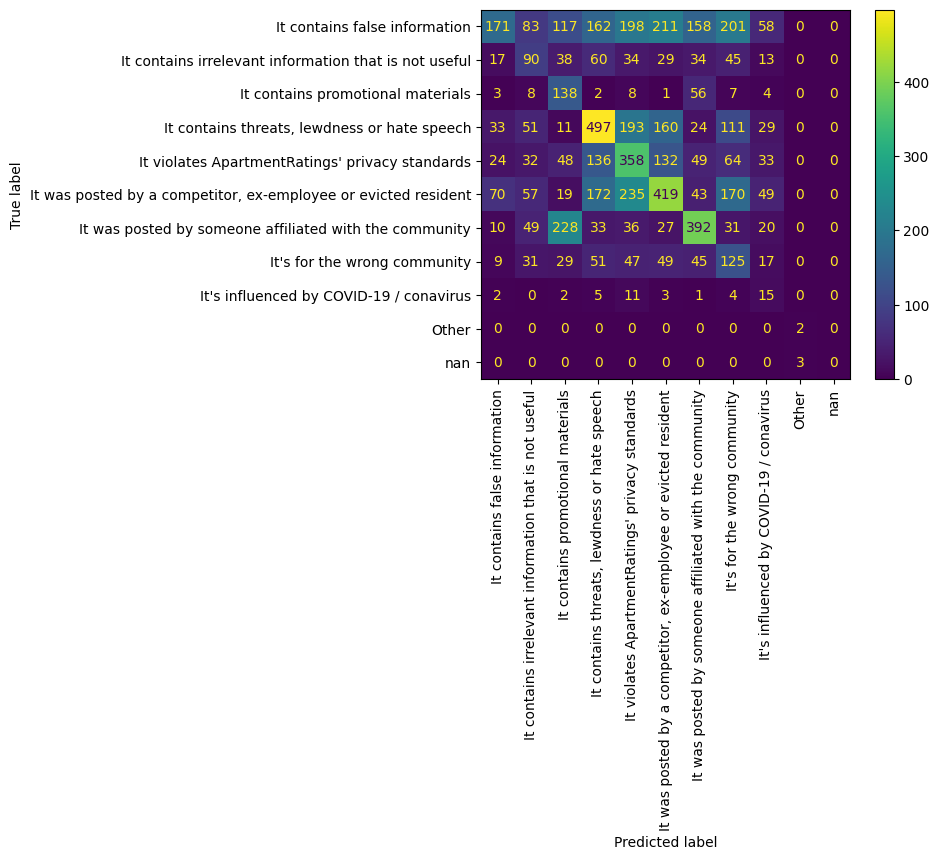

In [5]:
# Train a stable TF-IDF + numeric features + Logistic Regression (saga)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Simple cleaner for text
class TextCleaner:
    def fit(self, X, y=None): return self
    def transform(self, X):
        import pandas as pd, re
        s = pd.Series(X).fillna("").str.lower()
        s = s.str.replace(r"\s+", " ", regex=True).str.strip()
        return s.values

text_tfidf = Pipeline([
    ("clean", TextCleaner()),
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1,1), stop_words="english"))
])

preproc = ColumnTransformer(
    transformers=[
        ("text", text_tfidf, "text"),
        ("num", StandardScaler(with_mean=False), ["text_len","upper_words","exclamation","punctuation"]),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

clf = LogisticRegression(
    solver="saga",
    max_iter=8000,
    tol=1e-3,
    C=0.5,
    penalty="l2",
    class_weight="balanced",
    n_jobs=1
)

pipe = Pipeline([
    ("pre", preproc),
    ("clf", clf)
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print(classification_report(y_test, pred))
print("macro F1:", round(f1_score(y_test, pred, average="macro"), 4))
print("weighted F1:", round(f1_score(y_test, pred, average="weighted"), 4))

# Confusion matrix
fig = plt.figure(figsize=(9,7))
ConfusionMatrixDisplay.from_predictions(y_test, pred, xticks_rotation=90)
plt.tight_layout(); plt.show()


In [6]:
# Save trained pipeline and top tokens per class for interpretation
import os, joblib
import numpy as np
import pandas as pd

os.makedirs("../models", exist_ok=True)
MODEL_PATH = "../models/lr_tfidf_num_v1.joblib"
joblib.dump(pipe, MODEL_PATH)
print("Saved model to:", MODEL_PATH)

# Extract TF-IDF feature names
tfidf = pipe.named_steps["pre"].named_transformers_["text"].named_steps["tfidf"]
text_features = tfidf.get_feature_names_out().tolist()
num_features = ["text_len","upper_words","exclamation","punctuation"]
feature_names = text_features + num_features

# Per-class top tokens (by coefficient)
lr = pipe.named_steps["clf"]
classes = lr.classes_
coefs = lr.coef_

rows = []
for ci, cls in enumerate(classes):
    row = coefs[ci]
    # focus on text part for readability
    text_part = row[:len(text_features)]
    idx = np.argsort(text_part)[::-1][:25]
    for rank, i in enumerate(idx, start=1):
        rows.append({"class": cls, "rank": rank, "token": text_features[i], "weight": float(text_part[i])})

df_top = pd.DataFrame(rows)
os.makedirs("../reports", exist_ok=True)
TOP_PATH = "../reports/top_tokens_per_class.csv"
df_top.to_csv(TOP_PATH, index=False)
print("Saved top tokens to:", TOP_PATH)
df_top.head(10)


Saved model to: ../models/lr_tfidf_num_v1.joblib
Saved top tokens to: ../reports/top_tokens_per_class.csv


,class,rank,token,weight
0,It contains false information,1,terms,1.524461
1,It contains false information,2,approved,0.902891
2,It contains false information,3,called,0.808185
3,It contains false information,4,management,0.625013
4,It contains false information,5,lease,0.611365
5,It contains false information,6,rent,0.596748
6,It contains false information,7,said,0.569222
7,It contains false information,8,failed,0.558269
8,It contains false information,9,safety,0.527643
9,It contains false information,10,deposit,0.502126



Top 10 weighted words for class: It contains false information
['deposit' 'safety' 'failed' 'said' 'rent' 'lease' 'management' 'called'
 'approved' 'terms']

Top 10 weighted words for class: It contains irrelevant information that is not useful
['update' 'review' '¼ë' 'available' 'studio' 'thank' 'comments' 'good'
 '39' 'characters']

Top 10 weighted words for class: It contains promotional materials
['quiet' 'amazing' 'amenities' 'nice' 'sutton' 'staff' 'community' 'great'
 'love' 'friendly']

Top 10 weighted words for class: It contains threats, lewdness or hate speech
['rude' 'shit' 'bitch' 'ass' 'manager' 'people' 'ghetto' 'racist' 'black'
 'white']

Top 10 weighted words for class: It violates ApartmentRatings' privacy standards
['worst' 'horrible' 'corporate' 'customer' 'unprofessional' 'office'
 'leasing' 'residents' 'rude' 'manager']

Top 10 weighted words for class: It was posted by a competitor, ex-employee or evicted resident
['tenants' 'landlord' 'roaches' 'money' 'apos' '

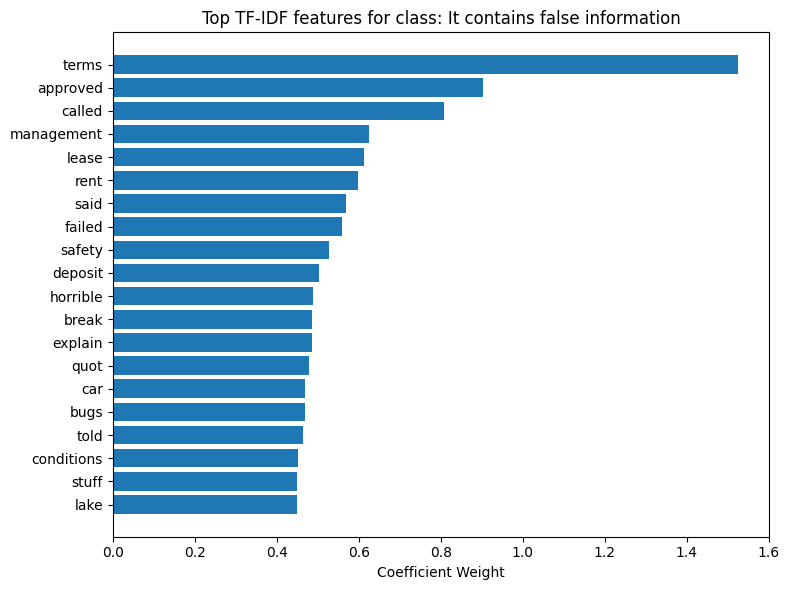

In [7]:
# --- Inspect top weighted TF-IDF features per class (robust to custom cleaner)

import numpy as np
import matplotlib.pyplot as plt

pre = pipe.named_steps["pre"]
clf = pipe.named_steps["clf"]

# 1) Get text-only feature names from the TF-IDF inside the text pipeline
tfidf = pre.named_transformers_["text"].named_steps["tfidf"]
text_feature_names = np.array(tfidf.get_feature_names_out())

# 2) Figure out how many TF-IDF columns there are, then slice classifier coefs
n_text = len(text_feature_names)            # e.g., 10000
coefs = clf.coef_                           # shape: (n_classes, n_text + n_num)
text_coefs = coefs[:, :n_text]              # front block = text features

# 3) Show top-N words for each class
TOP_N = 10
for i, cls in enumerate(clf.classes_):
    coef_i = text_coefs[i]
    top_idx = np.argsort(coef_i)[-TOP_N:]
    print(f"\nTop {TOP_N} weighted words for class: {cls}")
    print(text_feature_names[top_idx])

# 4) Optional: visualize top 20 words for one class
cls_index = 0  # change this to inspect another class
top20 = np.argsort(text_coefs[cls_index])[-20:]
plt.figure(figsize=(8, 6))
plt.barh(range(20), text_coefs[cls_index][top20])
plt.yticks(range(20), text_feature_names[top20])
plt.title(f"Top TF-IDF features for class: {clf.classes_[cls_index]}")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
plt.show()


In [8]:
# --- Label cleanup
MIN_CLASS_COUNT = 30  # merge rare labels into "Other"

y_counts = y_train.value_counts()
rare_classes = set(y_counts[y_counts < MIN_CLASS_COUNT].index)

def squash_rare(lbl):
    return "Other" if lbl in rare_classes else lbl

y_train = y_train.map(squash_rare)
y_test  = y_test.map(lambda z: "Other" if z in rare_classes else z)

print("Classes after merge:", y_train.value_counts())


Classes after merge: reason_fixed
It contains false information                                     5435
It was posted by a competitor, ex-employee or evicted resident    4933
It contains threats, lewdness or hate speech                      4437
It violates ApartmentRatings' privacy standards                   3505
It was posted by someone affiliated with the community            3303
It's for the wrong community                                      1614
It contains irrelevant information that is not useful             1438
It contains promotional materials                                  908
It's influenced by COVID-19 / conavirus                            170
Other                                                               21
Name: count, dtype: int64


In [9]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_test, pred, output_dict=True, zero_division=0)
per_class = pd.DataFrame(report).T.reset_index().rename(columns={"index": "label"})
per_class = per_class[per_class["label"].isin(sorted(y_test.unique()))]
per_class = per_class.sort_values("f1-score", ascending=True)
per_class.head(15)


,label,precision,recall,f1-score,support
8,It's influenced by COVID-19 / conavirus,0.063025,0.348837,0.106762,43.0
0,It contains false information,0.504425,0.125828,0.201413,1359.0
7,It's for the wrong community,0.164908,0.310174,0.215332,403.0
1,It contains irrelevant information that is not...,0.224439,0.250000,0.236531,360.0
2,It contains promotional materials,0.219048,0.607930,0.322054,227.0
4,It violates ApartmentRatings' privacy standards,0.319643,0.408676,0.358717,876.0
5,"It was posted by a competitor, ex-employee or ...",0.406402,0.339546,0.369978,1234.0
3,"It contains threats, lewdness or hate speech",0.444544,0.448151,0.446340,1109.0
6,It was posted by someone affiliated with the c...,0.488778,0.474576,0.481572,826.0
9,Other,1.000000,1.000000,1.000000,5.0


In [10]:
import numpy as np

labels = sorted(pd.Index(y_test.unique()).union(pd.Index(pred)))
cm = confusion_matrix(y_test, pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

pairs = []
for i, true_lbl in enumerate(labels):
    for j, pred_lbl in enumerate(labels):
        if i != j and cm[i, j] > 0:
            pairs.append((true_lbl, pred_lbl, int(cm[i, j])))
top_pairs = pd.DataFrame(pairs, columns=["true", "pred", "count"]).sort_values("count", ascending=False)
top_pairs.head(15)


,true,pred,count
44,"It was posted by a competitor, ex-employee or ...",It violates ApartmentRatings' privacy standards,235
50,It was posted by someone affiliated with the c...,It contains promotional materials,228
4,It contains false information,"It was posted by a competitor, ex-employee or ...",211
6,It contains false information,It's for the wrong community,201
3,It contains false information,It violates ApartmentRatings' privacy standards,198
27,"It contains threats, lewdness or hate speech",It violates ApartmentRatings' privacy standards,193
43,"It was posted by a competitor, ex-employee or ...","It contains threats, lewdness or hate speech",172
46,"It was posted by a competitor, ex-employee or ...",It's for the wrong community,170
2,It contains false information,"It contains threats, lewdness or hate speech",162
28,"It contains threats, lewdness or hate speech","It was posted by a competitor, ex-employee or ...",160


In [11]:
test_df = X_test.copy()
test_df = test_df.assign(true=y_test.values, pred=pred)

tgt_true, tgt_pred = top_pairs.iloc[0]["true"], top_pairs.iloc[0]["pred"]
print("Inspecting confusion between:", tgt_true, "→", tgt_pred)

sample_bad = test_df[(test_df.true==tgt_true) & (test_df.pred==tgt_pred)]
sample_bad[["text", "true", "pred"]].head(10)


Inspecting confusion between: It was posted by a competitor, ex-employee or evicted resident → It violates ApartmentRatings' privacy standards


,text,true,pred
22715,This place is a nightmare. The maintenance ma...,"It was posted by a competitor, ex-employee or ...",It violates ApartmentRatings' privacy standards
6535,I have a ton of photos posted of Advenir on Ad...,"It was posted by a competitor, ex-employee or ...",It violates ApartmentRatings' privacy standards
21736,"There are issues with trash pick up, parking, ...","It was posted by a competitor, ex-employee or ...",It violates ApartmentRatings' privacy standards
20736,"Decent apartments, but rude management who wil...","It was posted by a competitor, ex-employee or ...",It violates ApartmentRatings' privacy standards
10713,"The staff are COMPLETELY TERRIBLE. Very rude, ...","It was posted by a competitor, ex-employee or ...",It violates ApartmentRatings' privacy standards
14716,My guests and I we&apos;re treated disrespectf...,"It was posted by a competitor, ex-employee or ...",It violates ApartmentRatings' privacy standards
28007,I am stuck living in Scandia Apartments for on...,"It was posted by a competitor, ex-employee or ...",It violates ApartmentRatings' privacy standards
20891,"There is no manager on duty, cant get a hold a...","It was posted by a competitor, ex-employee or ...",It violates ApartmentRatings' privacy standards
9317,There is so much negative about Eden I don&apo...,"It was posted by a competitor, ex-employee or ...",It violates ApartmentRatings' privacy standards
8177,To whomever I just spoke with. You were extrem...,"It was posted by a competitor, ex-employee or ...",It violates ApartmentRatings' privacy standards


In [12]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

text_tfidf = Pipeline([
    ("clean", TextCleaner()),
    ("tfidf", TfidfVectorizer(max_features=15000, ngram_range=(1,2), stop_words="english"))
])

pre = ColumnTransformer([
    ("text", text_tfidf, "text"),
    ("num", StandardScaler(with_mean=False), ["text_len","upper_words","exclamation","punctuation"])
], sparse_threshold=0.3)

svm = LinearSVC(C=1.0, class_weight="balanced")

svm_pipe = Pipeline([("pre", pre), ("clf", svm)])
svm_pipe.fit(X_train, y_train)
svm_pred = svm_pipe.predict(X_test)

print(classification_report(y_test, svm_pred, zero_division=0))
print("macro F1:", round(f1_score(y_test, svm_pred, average="macro"), 4))


                                                                precision    recall  f1-score   support

                                 It contains false information       0.54      0.44      0.48      1359
         It contains irrelevant information that is not useful       0.33      0.40      0.36       360
                             It contains promotional materials       0.32      0.41      0.36       227
                  It contains threats, lewdness or hate speech       0.55      0.54      0.54      1109
               It violates ApartmentRatings' privacy standards       0.44      0.42      0.43       876
It was posted by a competitor, ex-employee or evicted resident       0.56      0.55      0.56      1234
        It was posted by someone affiliated with the community       0.53      0.62      0.57       826
                                  It's for the wrong community       0.27      0.30      0.29       403
                       It's influenced by COVID-19 / conavirus 

In [13]:
char_tfidf = Pipeline([
    ("clean", TextCleaner()),
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=30000))
])

pre_char = ColumnTransformer([("textc", char_tfidf, "text")], sparse_threshold=0.3)
svm_char = Pipeline([("pre", pre_char), ("clf", LinearSVC(C=0.5, class_weight="balanced"))])

svm_char.fit(X_train, y_train)
char_pred = svm_char.predict(X_test)

print(classification_report(y_test, char_pred, zero_division=0))
print("macro F1:", round(f1_score(y_test, char_pred, average="macro"), 4))


/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                                                                precision    recall  f1-score   support

                                 It contains false information       0.53      0.37      0.43      1359
         It contains irrelevant information that is not useful       0.29      0.36      0.32       360
                             It contains promotional materials       0.31      0.44      0.36       227
                  It contains threats, lewdness or hate speech       0.53      0.54      0.53      1109
               It violates ApartmentRatings' privacy standards       0.44      0.41      0.42       876
It was posted by a competitor, ex-employee or evicted resident       0.56      0.53      0.54      1234
        It was posted by someone affiliated with the community       0.53      0.67      0.59       826
                                  It's for the wrong community       0.27      0.32      0.30       403
                       It's influenced by COVID-19 / conavirus 

In [14]:
# Re-create the char-level SVM pipeline (no fitting here)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Minimal cleaner (same interface as before)
class TextCleaner:
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        import pandas as pd, re
        s = pd.Series(X).fillna("").str.lower()
        s = s.str.replace(r"\s+", " ", regex=True).str.strip()
        return s.values

# Char-level TF-IDF pipeline
char_tfidf = Pipeline([
    ("clean", TextCleaner()),
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=30000))
])

# ColumnTransformer that applies char TF-IDF to the "text" column
pre_char = ColumnTransformer(
    transformers=[("textc", char_tfidf, "text")],
    sparse_threshold=0.3
)

# LinearSVC classifier (no training yet)
svm_char = Pipeline([
    ("pre", pre_char),
    ("clf", LinearSVC(C=0.5, class_weight="balanced", max_iter=5000))
])

# Quick sanity check: list some parameter keys so downstream code can use them
print("Sample keys containing 'tfidf' (char pipeline):")
print(sorted([k for k in svm_char.get_params().keys() if "tfidf" in k])[:15])


Sample keys containing 'tfidf' (char pipeline):
['pre__textc__tfidf', 'pre__textc__tfidf__analyzer', 'pre__textc__tfidf__binary', 'pre__textc__tfidf__decode_error', 'pre__textc__tfidf__dtype', 'pre__textc__tfidf__encoding', 'pre__textc__tfidf__input', 'pre__textc__tfidf__lowercase', 'pre__textc__tfidf__max_df', 'pre__textc__tfidf__max_features', 'pre__textc__tfidf__min_df', 'pre__textc__tfidf__ngram_range', 'pre__textc__tfidf__norm', 'pre__textc__tfidf__preprocessor', 'pre__textc__tfidf__smooth_idf']


In [15]:
# --- Final stratified split for model training ---

from sklearn.model_selection import train_test_split

# Select text and numeric columns
X = df[["text", "text_len", "upper_words", "exclamation", "punctuation"]].copy()
y = df["reason_fixed"]

TEST_SIZE = 0.2  # keep consistent with previous settings

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

print("Shapes:", X_train.shape, X_test.shape)
print("Classes:", y.nunique())

# Fill missing values to avoid NaN during model training
for c in ["text_len", "upper_words", "exclamation", "punctuation"]:
    if c in X_train.columns:
        X_train[c] = X_train[c].fillna(0)
        X_test[c] = X_test[c].fillna(0)

X_train["text"] = X_train["text"].fillna("")
X_test["text"] = X_test["text"].fillna("")

print("✅ Training/test data prepared successfully.")


Shapes: (25764, 5) (6442, 5)
Classes: 11
✅ Training/test data prepared successfully.


In [16]:
# --- Char-level TF-IDF + LinearSVC grid search (clean, self-contained) ---

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score

# Safety checks: make sure training/test splits exist
assert "X_train" in globals() and "y_train" in globals(), "X_train/y_train not found."
assert "X_test" in globals() and "y_test" in globals(), "X_test/y_test not found."
assert "svm_char" in globals(), "svm_char pipeline not found. Run the char pipeline cell first."

# Define search grid using the correct parameter keys for the nested pipeline:
# pre (ColumnTransformer) -> "textc" (Pipeline) -> "tfidf" (TfidfVectorizer)
param_grid_char = {
    "pre__textc__tfidf__ngram_range": [(3, 5), (3, 6)],   # try char 3–5 vs 3–6
    "pre__textc__tfidf__max_features": [20000, 30000, 40000],  # vocabulary size
    "clf__C": [0.25, 0.5, 1.0],                           # SVM regularization
}

# Increase max_iter on the classifier to help convergence during CV
svm_char.set_params(clf__max_iter=8000)

gs_char = GridSearchCV(
    estimator=svm_char,
    param_grid=param_grid_char,
    scoring="f1_macro",
    cv=3,
    n_jobs=1,
    verbose=2  # show progress during CV
)

print("Running char-level TF-IDF + SVM grid search...")
gs_char.fit(X_train, y_train)

print("\nBest parameters found:")
print(gs_char.best_params_)
print("Best f1_macro (CV):", round(gs_char.best_score_, 4))

# Evaluate the best model on the test set
best_char = gs_char.best_estimator_
char_pred = best_char.predict(X_test)

print("\nTest set report (best char-level model):")
print(classification_report(y_test, char_pred, zero_division=0))
print("macro F1 (test):", round(f1_score(y_test, char_pred, average="macro"), 4))
print("weighted F1 (test):", round(f1_score(y_test, char_pred, average="weighted"), 4))


Running char-level TF-IDF + SVM grid search...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END clf__C=0.25, pre__textc__tfidf__max_features=20000, pre__textc__tfidf__ngram_range=(3, 5); total time=  26.2s
[CV] END clf__C=0.25, pre__textc__tfidf__max_features=20000, pre__textc__tfidf__ngram_range=(3, 5); total time=  26.8s
[CV] END clf__C=0.25, pre__textc__tfidf__max_features=20000, pre__textc__tfidf__ngram_range=(3, 5); total time=  27.1s
[CV] END clf__C=0.25, pre__textc__tfidf__max_features=20000, pre__textc__tfidf__ngram_range=(3, 6); total time=  43.4s
[CV] END clf__C=0.25, pre__textc__tfidf__max_features=20000, pre__textc__tfidf__ngram_range=(3, 6); total time=  36.5s
[CV] END clf__C=0.25, pre__textc__tfidf__max_features=20000, pre__textc__tfidf__ngram_range=(3, 6); total time=  34.8s
[CV] END clf__C=0.25, pre__textc__tfidf__max_features=30000, pre__textc__tfidf__ngram_range=(3, 5); total time=  25.9s
[CV] END clf__C=0.25, pre__textc__tfidf__max_features=30000

In [8]:
# --- Rebuild features and train/test split (run this first) ---

import pandas as pd
from sklearn.model_selection import train_test_split
import re, string

# 1) Load the cleaned CSV (adjust if your path differs)
try:
    df = pd.read_csv("../data/processed/reported_reviews_clean.csv")
except FileNotFoundError:
    df = pd.read_csv("data/processed/reported_reviews_clean.csv")

# 2) Basic numeric feature helpers
PUNCT = set(string.punctuation)

def count_upper_words(text: str) -> int:
    return sum(1 for w in re.findall(r"[A-Za-z]{2,}", str(text)) if w.isupper())

def count_exclamation(text: str) -> int:
    return str(text).count("!")

def count_punctuation(text: str) -> int:
    return sum(1 for ch in str(text) if ch in PUNCT)

# 3) Build text & numeric features
df["text"] = df["review_text"].astype(str)
df["text_len"] = df["text"].str.len()
df["upper_words"] = df["text"].apply(count_upper_words)
df["exclamation"] = df["text"].apply(count_exclamation)
df["punctuation"] = df["text"].apply(count_punctuation)

# 4) Clean labels; ensure every class has >= 2 samples for stratify
df["reason_fixed"] = df["reason"].astype(str).str.strip().replace({"nan": "Other"})
vc = df["reason_fixed"].value_counts()
keep = vc[vc >= 2].index
df = df[df["reason_fixed"].isin(keep)].copy()

# 5) Split
X = df[["text", "text_len", "upper_words", "exclamation", "punctuation"]]
y = df["reason_fixed"]

TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

# 6) Safety: fill NaN in numeric cols
for c in ["text_len","upper_words","exclamation","punctuation"]:
    X_train[c] = X_train[c].fillna(0)
    X_test[c]  = X_test[c].fillna(0)

print("Shapes:", X_train.shape, X_test.shape)
print("Classes:", y.nunique())


Shapes: (25762, 5) (6441, 5)
Classes: 13


In [9]:
# --- Define char-level TF-IDF + LinearSVC pipeline (svm_char) ---

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Minimal cleaner used earlier
class TextCleaner:
    def fit(self, X, y=None): return self
    def transform(self, X):
        import pandas as pd, re
        s = pd.Series(X).fillna("").str.lower()
        s = s.str.replace(r"\s+", " ", regex=True).str.strip()
        return s.values

char_tfidf = Pipeline([
    ("clean", TextCleaner()),
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=30000))
])

pre_char = ColumnTransformer(
    transformers=[("textc", char_tfidf, "text")],
    sparse_threshold=0.3
)

svm_char = Pipeline([
    ("pre", pre_char),
    ("clf", LinearSVC(C=0.5, class_weight="balanced"))
])

print("svm_char is ready.")


svm_char is ready.


In [22]:
# --- Clean rows before stratified train/test split ---
import pandas as pd
from sklearn.model_selection import train_test_split

# 1) Load data
df = pd.read_csv("../data/processed/reported_reviews_clean.csv")

# 2) Basic sanitation: drop rows with null/empty text or label
df["review_text"] = df["review_text"].astype(str)
df["reason"] = df["reason"].astype(str)

mask = (
    df["review_text"].notna() &
    df["reason"].notna() &
    df["review_text"].str.strip().ne("") &
    df["reason"].str.strip().ne("") &
    (df["reason"].str.lower() != "nan")  # guard against literal "nan" strings
)
df_clean = df.loc[mask].copy()

# 3) Ensure text_len exists and has no NaN
if "text_len" not in df_clean.columns:
    df_clean["text_len"] = df_clean["review_text"].str.len()
else:
    # fill missing text_len using actual string length
    na_len = df_clean["text_len"].isna()
    df_clean.loc[na_len, "text_len"] = df_clean.loc[na_len, "review_text"].str.len()

# 4) For stratification: remove classes with fewer than 2 samples
vc = df_clean["reason"].value_counts()
valid_classes = vc[vc >= 2].index
df_clean = df_clean[df_clean["reason"].isin(valid_classes)].copy()

print("After cleaning:")
print("  rows:", len(df_clean))
print("  classes:", df_clean["reason"].nunique())
print("  min class count:", df_clean["reason"].value_counts().min())

# 5) Build X/y and split
X = df_clean[["review_text", "text_len"]].rename(columns={"review_text": "text"})
y = df_clean["reason"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Train/test split OK.")
print("   X_train:", X_train.shape, "| X_test:", X_test.shape)


After cleaning:
  rows: 32187
  classes: 12
  min class count: 2
✅ Train/test split OK.
   X_train: (25749, 2) | X_test: (6438, 2)


gs_char not found; refitting svm_char with best params found earlier...


/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                                                                precision    recall  f1-score   support

                                                            16       0.00      0.00      0.00         1
                                 It contains false information       0.55      0.43      0.48      1359
         It contains irrelevant information that is not useful       0.30      0.35      0.33       360
                             It contains promotional materials       0.31      0.44      0.37       227
                  It contains threats, lewdness or hate speech       0.54      0.54      0.54      1109
               It violates ApartmentRatings' privacy standards       0.44      0.41      0.43       876
It was posted by a competitor, ex-employee or evicted resident       0.57      0.55      0.56      1234
        It was posted by someone affiliated with the community       0.54      0.65      0.59       826
                                  It's for the wrong community 

/var/folders/gz/bhmz7vj94s7207h9k2_rgndc0000gn/T/ipykernel_84173/1434558295.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

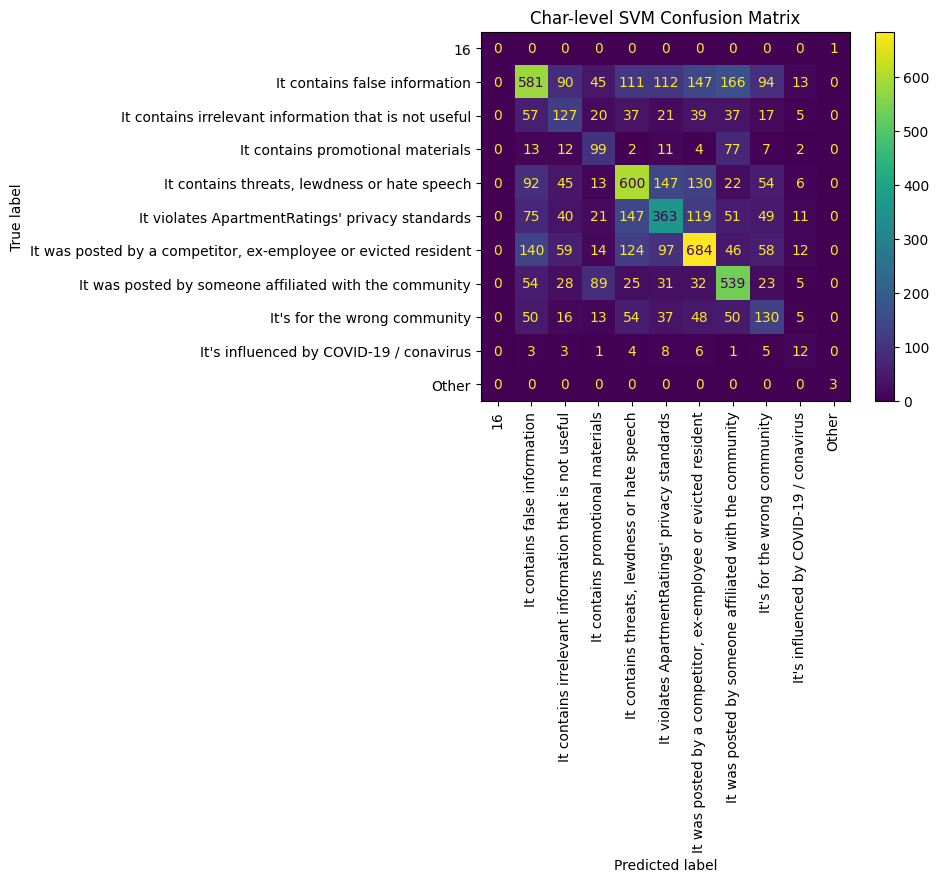

In [10]:
# --- Build or recover best char-level SVM model, then interpret/visualize ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score

# 1) Ensure train/test and base pipeline exist
assert "X_train" in globals() and "y_train" in globals(), "X_train/y_train not found. Run the data split cell first."
assert "X_test" in globals() and "y_test" in globals(), "X_test/y_test not found. Run the data split cell first."
assert "svm_char" in globals(), "svm_char pipeline not found. Run the char pipeline definition cell first."

# 2) Get best model: prefer grid search result if available; otherwise set best params and fit
try:
    best_model = gs_char.best_estimator_
    print("Using best_estimator_ from gs_char.")
except Exception:
    print("gs_char not found; refitting svm_char with best params found earlier...")
    best_params = {
        "clf__C": 1.0,
        "pre__textc__tfidf__max_features": 40000,
        "pre__textc__tfidf__ngram_range": (3, 5),
    }
    svm_char.set_params(**best_params)
    best_model = svm_char.fit(X_train, y_train)

# 3) Extract classifier and vectorizer for feature names
clf = best_model.named_steps["clf"]
tfidf = best_model.named_steps["pre"].named_transformers_["textc"].named_steps["tfidf"]
feature_names = np.array(tfidf.get_feature_names_out())

# 4) Quick test report to confirm the model runs
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
print("macro F1:", round(f1_score(y_test, y_pred, average="macro"), 4))
print("weighted F1:", round(f1_score(y_test, y_pred, average="weighted"), 4))

# 5) Show top features per class
for i, cls in enumerate(clf.classes_):
    top10_idx = np.argsort(clf.coef_[i])[-10:]
    print(f"\nTop 10 features for class '{cls}':")
    print(feature_names[top10_idx])

# 6) Confusion matrix
fig = plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=90)
plt.title("Char-level SVM Confusion Matrix")
plt.tight_layout()
plt.show()


In [11]:
# --- Clean labels: keep only valid classes and drop stray ones ---

VALID_CLASSES = [
    "It contains false information",
    "It was posted by a competitor, ex-employee or evicted resident",
    "It contains threats, lewdness or hate speech",
    "It violates ApartmentRatings' privacy standards",
    "It was posted by someone affiliated with the community",
    "It's for the wrong community",
    "It contains irrelevant information that is not useful",
    "It contains promotional materials",
    "It's influenced by COVID-19 / conavirus",
    "Other",   # keep only if you really want this bucket
]

# Start from your current df; remove literal 'nan' strings and unknown codes like '12','13','16'
df = df.copy()
df["reason_fixed"] = df["reason_fixed"].astype(str).str.strip()

# Drop literal 'nan' (string) and numeric-coded leftovers
mask_valid = df["reason_fixed"].isin(VALID_CLASSES)
before, after = df.shape[0], mask_valid.sum()
print(f"Rows before: {before}  |  after keeping valid classes: {after}  |  dropped: {before - after}")

df = df.loc[mask_valid].copy()


Rows before: 32203  |  after keeping valid classes: 32196  |  dropped: 7


In [12]:
# --- Re-split and re-train with the best char-level SVM params ---

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score

# Rebuild X/y from the cleaned frame
num_cols = ["text_len", "upper_words", "exclamation", "punctuation"]  # adjust if needed
X = df[["text"] + num_cols].copy()
y = df["reason_fixed"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Best char-level pipeline (from your grid search results)
char_tfidf = TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=40000)

pre_char = ColumnTransformer(
    transformers=[("textc", Pipeline([("tfidf", char_tfidf)]), "text")],
    remainder="drop",
    sparse_threshold=0.3
)

svm_char = Pipeline([
    ("pre", pre_char),
    ("clf", LinearSVC(C=1.0, class_weight="balanced"))
])

svm_char.fit(X_train, y_train)
pred = svm_char.predict(X_test)

print(classification_report(y_test, pred, zero_division=0))
print("macro F1:", round(f1_score(y_test, pred, average="macro"), 4))
print("weighted F1:", round(f1_score(y_test, pred, average="weighted"), 4))


/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                                                                precision    recall  f1-score   support

                                 It contains false information       0.55      0.43      0.48      1359
         It contains irrelevant information that is not useful       0.33      0.36      0.34       360
                             It contains promotional materials       0.33      0.42      0.37       227
                  It contains threats, lewdness or hate speech       0.54      0.53      0.53      1109
               It violates ApartmentRatings' privacy standards       0.44      0.42      0.43       876
It was posted by a competitor, ex-employee or evicted resident       0.56      0.56      0.56      1234
        It was posted by someone affiliated with the community       0.54      0.66      0.59       826
                                  It's for the wrong community       0.30      0.33      0.31       403
                       It's influenced by COVID-19 / conavirus 

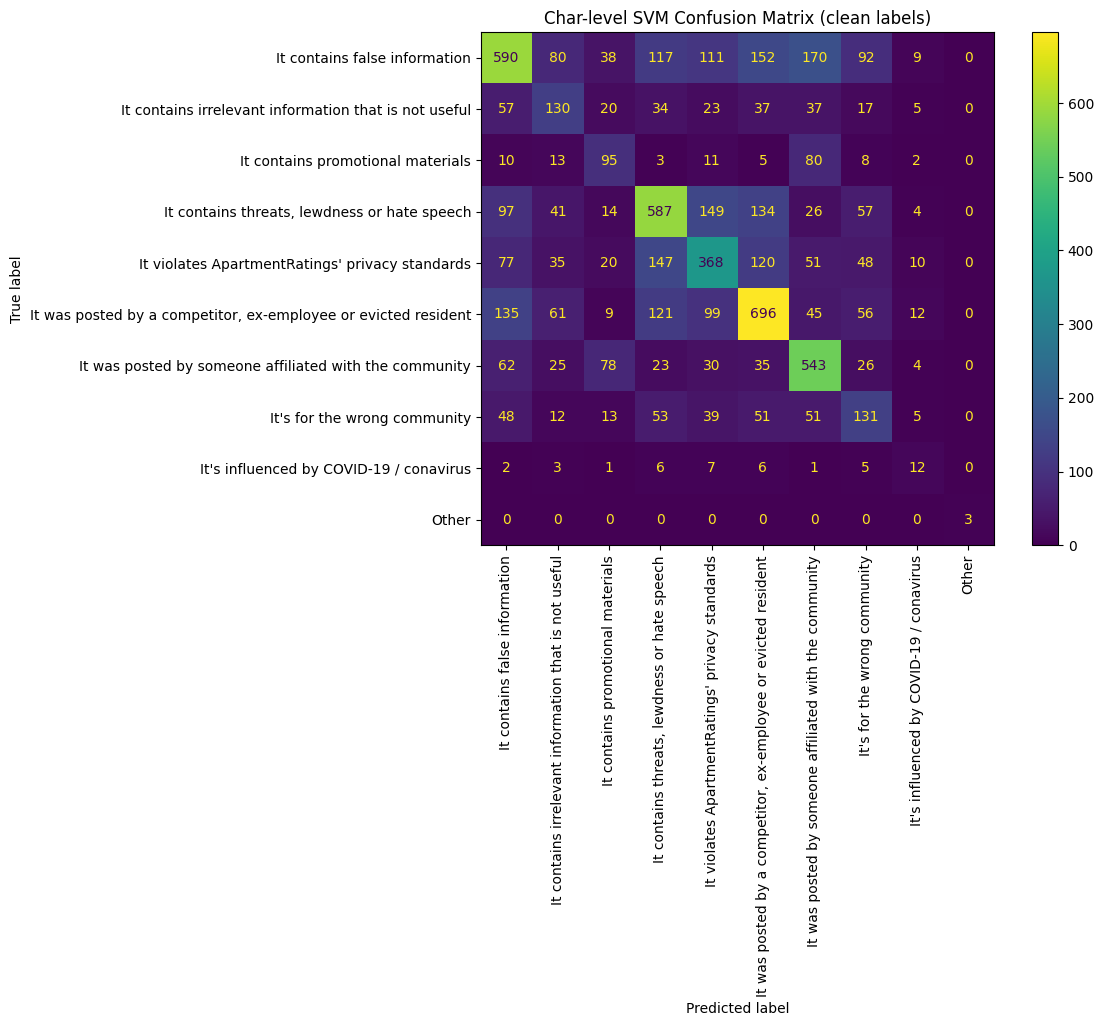

In [13]:
# --- Confusion matrix with clearer layout ---

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(11, 9))  # larger canvas helps labels fit
ConfusionMatrixDisplay.from_predictions(
    y_test, pred, xticks_rotation=90, values_format="d", ax=ax
)
ax.set_title("Char-level SVM Confusion Matrix (clean labels)")
# Leave extra bottom margin for rotated x labels
plt.subplots_adjust(bottom=0.35, left=0.28, right=0.98, top=0.92)
plt.show()


gs_char not available; refitting svm_char with previously found best params...


/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



=== Test set report ===
                                                                precision    recall  f1-score   support

                                 It contains false information       0.55      0.43      0.48      1359
         It contains irrelevant information that is not useful       0.33      0.36      0.34       360
                             It contains promotional materials       0.33      0.42      0.37       227
                  It contains threats, lewdness or hate speech       0.54      0.53      0.53      1109
               It violates ApartmentRatings' privacy standards       0.44      0.42      0.43       876
It was posted by a competitor, ex-employee or evicted resident       0.56      0.56      0.56      1234
        It was posted by someone affiliated with the community       0.54      0.66      0.59       826
                                  It's for the wrong community       0.30      0.33      0.31       403
                       It's influenced

/var/folders/gz/bhmz7vj94s7207h9k2_rgndc0000gn/T/ipykernel_84173/2932490467.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

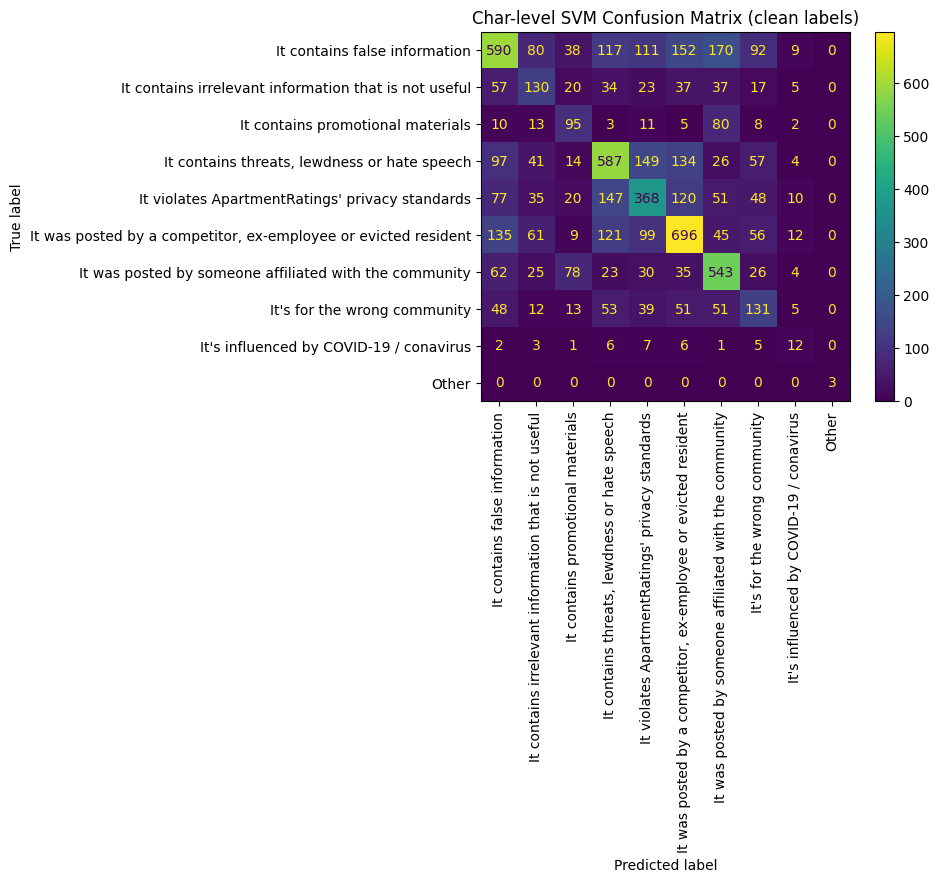


=== Top 20 char-ngrams per class ===

Class: It contains false information
) w, le pl, e ac, em m, e. st, t a w, osa, ve v, ce on, an ex, acks, wn fo, den , his s, ce al, he do, e con, ne ne, e lak, is cl

Class: It contains irrelevant information that is not useful
ap a, ama, te. i, cheat, ance., sks, ooooo, joi, hhhhh, lakes, a v, sss, f f, on!, a n, ggg,  ì , ghj, h g, djd

Class: It contains promotional materials
rei, s be, tive , ind, , n a t, ! p, are w, . mai, e ap, o clu, re at, e lan, nbe, ida,  n ,  ben, og pa, ben, dan, e apa

Class: It contains threats, lewdness or hate speech
 ghet, fuck, fucki, rant ,  no t,  ga, de. s, k n, mmi,  rap,  , , sian, black, blac,  blac, ***,  gh, ndia, india, ndian

Class: It violates ApartmentRatings' privacy standards
n't , na an, . te,  ang, s peo, , de, ie ,  ka, ove i, na , e had, lici, ime a,  er, andr,  me s, pat, ca , arie, sha

Class: It was posted by a competitor, ex-employee or evicted resident
er so, it..., ya , ve o, is bu, t of

In [15]:
# === Finalize: evaluate, visualize, and export the best char-level SVM ===
# Notes are in English as requested.

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
import joblib

# 0) Preconditions
assert "X_train" in globals() and "y_train" in globals()
assert "X_test" in globals() and "y_test" in globals()
assert "svm_char" in globals() or "gs_char" in globals()

# 1) Get the best model (prefer grid-search result if available)
try:
    best_model = gs_char.best_estimator_
    print("Using best_estimator_ from gs_char.")
except Exception:
    print("gs_char not available; refitting svm_char with previously found best params...")
    svm_char.set_params(
        clf__C=1.0,
        pre__textc__tfidf__max_features=40000,
        pre__textc__tfidf__ngram_range=(3, 5),
    )
    best_model = svm_char.fit(X_train, y_train)

# 2) Quick evaluation on test set
y_pred = best_model.predict(X_test)
print("\n=== Test set report ===")
print(classification_report(y_test, y_pred, zero_division=0))
print("macro F1:", round(f1_score(y_test, y_pred, average="macro"), 4))
print("weighted F1:", round(f1_score(y_test, y_pred, average="weighted"), 4))

# 3) Confusion matrix
fig = plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=90)
plt.title("Char-level SVM Confusion Matrix (clean labels)")
plt.tight_layout()
plt.show()

# 4) Show top features per class (character n-grams with highest weights)
clf = best_model.named_steps["clf"]
tfidf = best_model.named_steps["pre"].named_transformers_["textc"].named_steps["tfidf"]
feature_names = np.array(tfidf.get_feature_names_out())

print("\n=== Top 20 char-ngrams per class ===")
for i, cls in enumerate(clf.classes_):
    top_idx = np.argsort(clf.coef_[i])[-20:]
    top_feats = feature_names[top_idx]
    print(f"\nClass: {cls}")
    print(", ".join(top_feats))

# 5) Export model and label list
os.makedirs("artifacts", exist_ok=True)
model_path = "artifacts/model_char_svm.pkl"
labels_path = "artifacts/labels.npy"

joblib.dump(best_model, model_path)
np.save(labels_path, clf.classes_)
print(f"\nSaved model to: {model_path}")
print(f"Saved label list to: {labels_path}")

# 6) Lightweight inference helper (fixed: wrap list into a DataFrame with column 'text')
def predict_reviews(raw_text_list):
    """
    Predict labels for a list of raw review strings using the exported pipeline.
    Input: list[str]
    Output: numpy.ndarray of predicted class names (strings)
    """
    import pandas as pd
    mdl = joblib.load("artifacts/model_char_svm.pkl")
    X = pd.DataFrame({"text": list(raw_text_list)})  # ColumnTransformer expects a 'text' column
    preds = mdl.predict(X)
    return preds

# Example
demo_preds = predict_reviews([
    "This review contains threatening language and offensive words.",
    "Marketing-only content about discounts and promotions.",
    "This seems to be posted by a competitor, not a real resident."
])
print("\nDemo predictions:", list(demo_preds))